- By: @MarcosLaffitte 
https://github.com/MarcosLaffitte

- Proj2: Coronavirus Dynamics; data set from: https://github.com/CSSEGISandData/COVID-19, up to april 02 2020

- Masters in Mathematics

- UNAM-IMATE, Juriquilla, Qro, Mex

- Course on Artificial Inteligence

- Prof: Esteban Hernandez Vargas, PhD

- Description: determine and evaluate models of coronavirus confirmed cases growth, considering cummulative data as net population of confirmed cases (exponential growth).

- Models:
        * 2nd degree polynomial
        * 3nd degree polynomial
        * 4nd degree polynomial
        * 5nd degree polynomial
        * exponential function
        * SIR
        
- data files                               
        * time_series_covid19_confirmed.csv


## Dependencies info

> PDEparams
  Home-page: https://github.com/cparrarojas/PDEparams

> scipy
  Version: 1.1.0
  Summary: SciPy: Scientific Library for Python
  Home-page: https://www.scipy.org

> seaborn
  Version: 0.9.0
  Summary: seaborn: statistical data visualization
  Home-page: https://seaborn.pydata.org

> numpy
  Version: 1.17.0
  Summary: NumPy is the fundamental package for array computing with Python.
  Home-page: https://www.numpy.org

> pandas
  Version: 0.25.1
  Summary: Powerful data structures for data analysis, time series, and statistics
  Home-page: http://pandas.pydata.org

> matplotlib
  Version: 3.0.2
  Summary: Python plotting package
  Home-page: http://matplotlib.org

> scikit-learn
  Version: 0.20.0
  Summary: A set of python modules for machine learning and data mining
  Home-page: http://scikit-learn.org

## Dependencies

In [1]:
# already in python --------------------------------------------------------------------------------
import math

# not in python ------------------------------------------------------------------------------------
import PDEparams as pde
from tqdm.auto import tqdm
import numpy.polynomial.polynomial as poly
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# some weird stuff ----------------------------------------------------------------------------------
%matplotlib inline
sns.set(rc={"figure.figsize":(11.7,8.27)})

## Variables

In [2]:
# input --------------------------------------------------------------------------------------------
# available countries: Italy, Japan, Spain, Germany, Iran, Mexico; and with tryout coefficientes below for SIR
theCountry = "Italy"
# train and test percentages
training = 0.6

# data ---------------------------------------------------------------------------------------------
timeSeriesConfirmed = []
timeSteps = 0
time = []

# constant -----------------------------------------------------------------------------------------
fileConfirmed = "time_series_covid19_confirmed.csv"
avilable = ["Italy", "Japan", "Spain", "Germany", "Iran", "Mexico"]
populationS = dict()
populationS["Italy"] = 60480000
populationS["Japan"] = 126800000
populationS["Spain"] = 46660000
populationS["Germany"] = 82790000
populationS["Iran"] = 81160000
populationS["Mexico"] = 129200000
test = 1 - training

# control ------------------------------------------------------------------------------------------
if(not theCountry in avilable):
    theCountry = "Italy"


## Functions

In [3]:
# SIR ----------------------------------------------------------------------------------------------
def SIR(z, t, b, g):
    S, I, R = z
    return([-b*S*I, b*S*I-g*I, g*I])

def initial_S():
    theInitial_S = naturalLogSusceptible[0]
    return(theInitial_S)

def initial_I():
    return(0.001)

def initial_R():
    return(0.001)

def runSIR(timeSteps, cb, cg):
    # local variables
    theResults = []
    S_t = initial_S()
    I_t = initial_I()
    R_t = initial_R()
    iS = 0
    iI = 0
    iR = 0
    h = 1/100
    # make time steps
    for i in range(0, timeSteps[-1] + 1):
        theResults.append(I_t)
        iS, iI, iR = SIR([S_t, I_t, R_t], i, cb, cg)
        S_tp1 = S_t + h*iS
        I_tp1 = I_t + h*iI
        R_tp1 = R_t + h*iR
        S_t = S_tp1
        I_t = I_tp1
        R_t = R_tp1
    # get results
    theResults = theResults[-len(timeSteps):]
    # return
    return(theResults)


In [4]:
# function: get data -------------------------------------------------------------------------------
def getData():
    # local variables
    theConfirmed = None
    theSusceptible = []
    theColumnHeaders = []
    firstColumn = ""
    secondColumn = ""
    thirdColumn = ""
    fourthColumn = ""
    theNa = []
    theInconsistenIndex = []
    colsConfirmed = []
    value = None
    initT = 0
    # get data
    theConfirmed = pd.read_csv(fileConfirmed)
    # get intial columns
    theColumnHeaders = list(theConfirmed.columns.values)
    firstColumn = theColumnHeaders[0]
    secondColumn = theColumnHeaders[1]
    thirdColumn = theColumnHeaders[2]
    fourthColumn = theColumnHeaders[3]
    # get data from whole countries
    theConfirmed = theConfirmed.drop([firstColumn, thirdColumn, fourthColumn], axis = 1).set_index(secondColumn).transpose()
    theConfirmed = theConfirmed.loc[:, ~theConfirmed.columns.duplicated(keep = False)]
    theConfirmed = list(theConfirmed[theCountry].values)
    initT = 0
    while(theConfirmed[initT] == 0):
        initT = initT + 1
    theConfirmed = theConfirmed[initT:]
    theSusceptible = [populationS[theCountry] - c for c in theConfirmed]
    # end of function
    return(theSusceptible, theConfirmed)


## Main

In [5]:
# get data
seriesSusceptible, seriesConfirmed = getData()
naturalLogSusceptible = [np.log(val) for val in seriesSusceptible]
naturalLogConfirmed = [np.log(val) for val in seriesConfirmed]
time = list(range(len(seriesConfirmed)))
mySeries = pd.DataFrame(list(zip(time, naturalLogConfirmed, naturalLogSusceptible)))
time_train, time_test, series_train_poly, series_test_poly = train_test_split(time, seriesConfirmed, test_size = test, shuffle = False)
time_train, time_test, series_train_exp, series_test_exp = train_test_split(time, naturalLogConfirmed, test_size = test, shuffle = False)
time_train, time_test, series_train_SIR, series_test_SIR = train_test_split(time, mySeries, test_size = test, shuffle = False)


In [6]:
# building models
coefPoly2 = poly.polyfit(time_train, series_train_poly, 2)
myPoly2 = poly.Polynomial(coefPoly2)
coefPoly3 = poly.polyfit(time_train, series_train_poly, 3)
myPoly3 = poly.Polynomial(coefPoly3)
coefPoly4 = poly.polyfit(time_train, series_train_poly, 4)
myPoly4 = poly.Polynomial(coefPoly4)
coefPoly5 = poly.polyfit(time_train, series_train_poly, 5)
myPoly5 = poly.Polynomial(coefPoly5)
coefExp = poly.polyfit(time_train, series_train_exp, 5)
myExp = poly.Polynomial(coefPoly5)
mySIR = pde.PDEmodel(series_train_SIR, SIR,
                     [initial_S, initial_I, initial_R],
                     bounds = [(0, 5), (0, 5)],
                     param_names = ["b", "g"],
                     nvars = 3, ndims = 0, nreplicates = 1,
                     obsidx = [0, 1], outfunc = None)
mySIR.fit(error = "rmse")
coefSIR = mySIR.best_params


          b         g
0  0.765565  0.000002


In [7]:
# obtaining predictions
# poly 2
poly2Learnt = np.asarray([myPoly2(eachTime) for eachTime in time_train])
poly2Prediction = np.asarray([myPoly2(eachTime) for eachTime in time_test])
poly2Curve = np.asarray([myPoly2(eachTime) for eachTime in time])
# poly 3
poly3Learnt = np.asarray([myPoly3(eachTime) for eachTime in time_train])
poly3Prediction = np.asarray([myPoly3(eachTime) for eachTime in time_test])
poly3Curve = np.asarray([myPoly3(eachTime) for eachTime in time])
# poly 4
poly4Learnt = np.asarray([myPoly4(eachTime) for eachTime in time_train])
poly4Prediction = np.asarray([myPoly4(eachTime) for eachTime in time_test])
poly4Curve = np.asarray([myPoly4(eachTime) for eachTime in time])
# poly 5
poly5Learnt = np.asarray([myPoly5(eachTime) for eachTime in time_train])
poly5Prediction = np.asarray([myPoly5(eachTime) for eachTime in time_test])
poly5Curve = np.asarray([myPoly5(eachTime) for eachTime in time])
# exp
expLearnt = np.asarray([myExp(eachTime) for eachTime in time_train])
expPrediction = np.asarray([myExp(eachTime) for eachTime in time_test])
expCurve = np.asarray([myExp(eachTime) for eachTime in time])
# SIR
sirLearnt = np.exp(np.asarray(runSIR(time_train, coefSIR["b"][0], coefSIR["g"][0])))
sirPrediction = np.exp(np.asarray(runSIR(time_test, coefSIR["b"][0], coefSIR["g"][0])))
sirCurve = np.exp(np.asarray(runSIR(time, coefSIR["b"][0], coefSIR["g"][0])))
# try out coefficients SIR -------------------------------------------
#sirLearnt = np.exp(np.asarray(runSIR(time_train, 1, 0.000002)))
#sirPrediction = np.exp(np.asarray(runSIR(time_test, 1, 0.000002)))
#sirCurve = np.exp(np.asarray(runSIR(time, 1, 0.000002)))
# try out coefficients SIR -------------------------------------------


In [8]:
# obtain aic
# get RSS train
poly2RSS = (1/2) * np.sum((series_train_poly - poly2Learnt)**2)
poly3RSS = (1/2) * np.sum((series_train_poly - poly3Learnt)**2)
poly4RSS = (1/2) * np.sum((series_train_poly - poly4Learnt)**2)
poly5RSS = (1/2) * np.sum((series_train_poly - poly5Learnt)**2)
expRSS = (1/2) * np.sum((series_train_poly - expLearnt)**2)
sirRSS = (1/2) * np.sum((series_train_poly - sirLearnt)**2)
# get AICv train
poly2AIC_train=len(series_train_poly)*math.log10(poly2RSS/len(series_train_poly))+2*len(coefPoly2)*len(series_train_poly)/(len(series_train_poly)-len(coefPoly2)-1)
poly3AIC_train=len(series_train_poly)*math.log10(poly3RSS/len(series_train_poly))+2*len(coefPoly3)*len(series_train_poly)/(len(series_train_poly)-len(coefPoly3)-1)
poly4AIC_train=len(series_train_poly)*math.log10(poly4RSS/len(series_train_poly))+2*len(coefPoly4)*len(series_train_poly)/(len(series_train_poly)-len(coefPoly4)-1)
poly5AIC_train=len(series_train_poly)*math.log10(poly5RSS/len(series_train_poly))+2*len(coefPoly5)*len(series_train_poly)/(len(series_train_poly)-len(coefPoly5)-1)
expAIC_train=len(series_train_poly)*math.log10(expRSS/len(series_train_poly))+2*len(coefExp)*len(series_train_poly)/(len(series_train_poly)-len(coefExp)-1)
sirAIC_train=len(series_train_poly)*math.log10(sirRSS/len(series_train_poly))+2*2*len(series_train_poly)/(len(series_train_poly)-2-1)
# get RSS test
poly2RSS = (1/2) * np.sum((series_test_poly - poly2Prediction)**2)
poly3RSS = (1/2) * np.sum((series_test_poly - poly3Prediction)**2)
poly4RSS = (1/2) * np.sum((series_test_poly - poly4Prediction)**2)
poly5RSS = (1/2) * np.sum((series_test_poly - poly5Prediction)**2)
expRSS = (1/2) * np.sum((series_test_poly - expPrediction)**2)
sirRSS = (1/2) * np.sum((series_test_poly - sirPrediction)**2)
# get AICv test
poly2AIC_test=len(series_test_poly)*math.log10(poly2RSS/len(series_test_poly))+2*len(coefPoly2)*len(series_test_poly)/(len(series_test_poly)-len(coefPoly2)-1)
poly3AIC_test=len(series_test_poly)*math.log10(poly3RSS/len(series_test_poly))+2*len(coefPoly3)*len(series_test_poly)/(len(series_test_poly)-len(coefPoly3)-1)
poly4AIC_test=len(series_test_poly)*math.log10(poly4RSS/len(series_test_poly))+2*len(coefPoly4)*len(series_test_poly)/(len(series_test_poly)-len(coefPoly4)-1)
poly5AIC_test=len(series_test_poly)*math.log10(poly5RSS/len(series_test_poly))+2*len(coefPoly5)*len(series_test_poly)/(len(series_test_poly)-len(coefPoly5)-1)
expAIC_test=len(series_test_poly)*math.log10(expRSS/len(series_test_poly))+2*len(coefExp)*len(series_test_poly)/(len(series_test_poly)-len(coefExp)-1)
sirAIC_test=len(series_test_poly)*math.log10(sirRSS/len(series_test_poly))+2*2*len(series_test_poly)/(len(series_test_poly)-2-1)


## Results

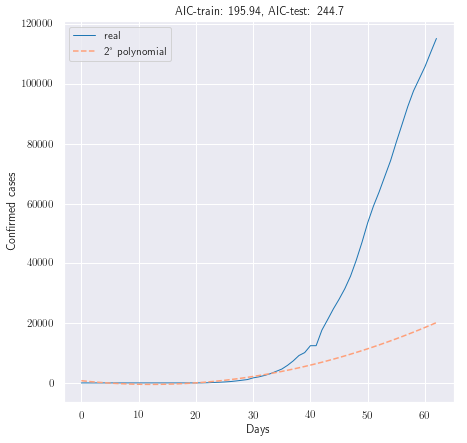

In [9]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(poly2Curve, linestyle = "--", linewidth = 1.5, color = "lightsalmon", label = "2° polynomial")
plt.title("AIC-train: " + str(round(poly2AIC_train, 2)) + ", AIC-test: " + str(round(poly2AIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()

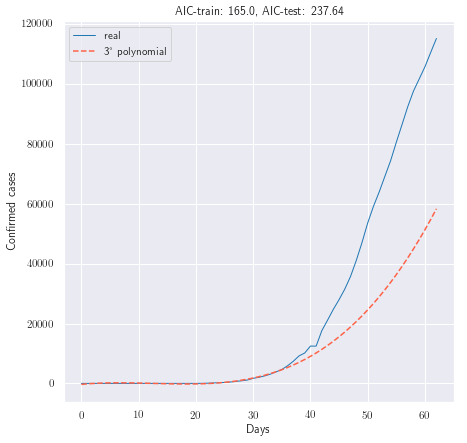

In [10]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(poly3Curve, linestyle = "--", linewidth = 1.5, color = "tomato", label = "3° polynomial")
plt.title("AIC-train: " + str(round(poly3AIC_train, 2)) + ", AIC-test: " + str(round(poly3AIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()

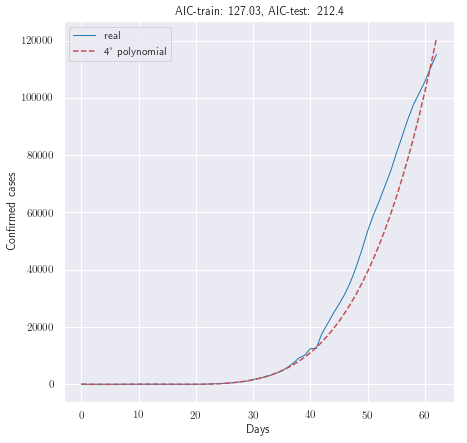

In [11]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(poly4Curve, linestyle = "--", linewidth = 1.5, color = "r", label = "4° polynomial")
plt.title("AIC-train: " + str(round(poly4AIC_train, 2)) + ", AIC-test: " + str(round(poly4AIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()

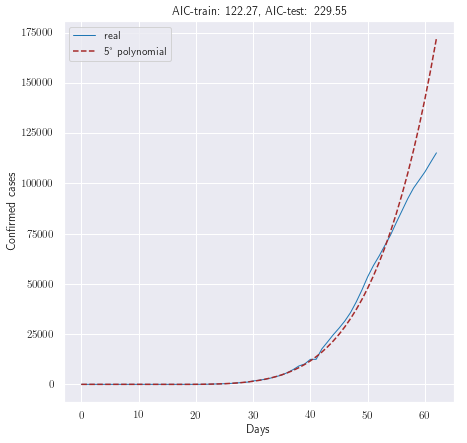

In [12]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(poly5Curve, linestyle = "--", linewidth = 1.5, color = "brown", label = "5° polynomial")
plt.title("AIC-train: " + str(round(poly5AIC_train, 2)) + ", AIC-test: " + str(round(poly5AIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()

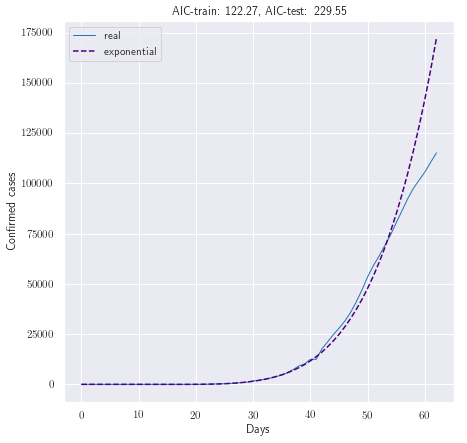

In [13]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(expCurve, linestyle = "--", linewidth = 1.5, color = "indigo", label = "exponential")
plt.title("AIC-train: " + str(round(expAIC_train, 2)) + ", AIC-test: " + str(round(expAIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()

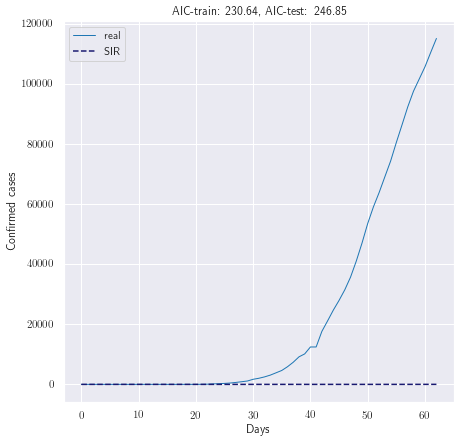

In [14]:
plt.figure(figsize = (7, 7))
plt.plot(seriesConfirmed, linewidth = 1, color = "tab:blue", label = "real")
plt.plot(sirCurve, linestyle = "--", linewidth = 1.5, color = "midnightblue", label = "SIR")
plt.title("AIC-train: " + str(round(sirAIC_train, 2)) + ", AIC-test: " + str(round(sirAIC_test, 2)))
plt.ylabel("Confirmed cases")
plt.xlabel("Days")
plt.legend()
plt.show()